In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, Model, utils, optimizers
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage

from tensorflow.keras.applications.vgg16 import VGG16

## TODO
<ul>
    <li>Look at RCNN</li>
    <li>Analyse X_train and y_train, make sure they are accurate</li>
    <li>Simplify untill overfit or loss too great for CNN + Dense</li>
    
</ul>


## Data Extraction

_Note that data extraction is slightly different for the RCNN approach and is done below_

In [2]:
PATH = os.getcwd()
dataset = os.path.join(PATH, 'find_phone')

with open(os.path.join(dataset,'labels.txt')) as inFile:
    labelData=inFile.readlines()

h = 163
w = 245 

X = []
y = []

for line in labelData:
    imName, x_i, y_i = line.split(' ')
    img = cv2.imread(os.path.join(dataset, imName),0)
    #img = cv2.imread(os.path.join(dataset, imName))
    X.append(np.expand_dims(cv2.resize(img, (w,h))/255, axis=2))
    y.append([float(x_i),float(y_i)])
X = np.asarray(X)
y = np.asarray(y)


## Data Augmentation

In [3]:
"""
The DataGenerator class takes a dataset of images and labels corresponding to a point on the image 
and applies basic data augmentation transformations.
"""
class DataGenerator():
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.t_min = 0
        self.t_max = 20
        self.h = self.X[0].shape[0]
        self.w = self.X[0].shape[1]
        self.gauss_mu = 0
        self.gauss_var_min = 0.0004
        self.gauss_var_max = 0.008
        self.sp_s_v_p_min = 0.2
        self.sp_s_v_p_max = 0.8
        self.sp_amount_min = 0.001
        self.sp_amount_max = 0.008
        self.prob_shift = 1
        self.prob_rotate = 1
        self.prob_noise = 1
        
    def shift(self,params):
        img, label = params
        
        #Obtain random number from unifrom probability distribution
        prob = np.random.uniform()
        
        if prob <= self.prob_shift:
            #Create translation vector and matrix
            t = np.random.randint(self.t_min,self.t_max,size=(label.shape))
            M = np.float32([[1,0,t[0]],[0,1,t[1]]])
            #obtain shifted image
            dst = cv2.warpAffine(img,M,(img.shape[1],img.shape[0]))
            #obtain new label
            new_label = label+t
        else:
            dst = img
            new_label = label
        return dst, new_label

    def rotate(self,params):
        img, label = params

        #Obtain random number from unifrom probability distribution
        prob = np.random.uniform()
        if prob <= self.prob_rotate:
            #Simple rotation, random chance of flipping lr or ud.
            p = np.random.randint(0,2)
            if p:
                dst = np.fliplr(img)
                new_label = [abs(self.w-label[0]),label[1]]
            else:
                dst = np.flipud(img)
                new_label = new_label = [label[0],abs(self.h-label[1])]
        else:
            dst = img
            new_label = label
        return dst, new_label
    
    def noise(self,params):
        img, label = params
        #Obtain random number from unifrom probability distribution
        prob = np.random.uniform()
        
        if prob<=self.prob_noise:        
            #random chance of gaussion noise or salt and pepper
            p = np.random.randint(0,2)
            if p == 0:
                #Choose random variation
                var = np.random.uniform(self.gauss_var_min, self.gauss_var_max)
                gauss = np.random.normal(self.gauss_mu, var**0.5, img.shape)
                noise = gauss.reshape(img.shape)
                dst = img+noise
            elif p == 1:
                sp_amount = np.random.uniform(self.sp_amount_min, self.sp_amount_max)
                sp_s_v_p = np.random.uniform(self.sp_s_v_p_min, self.sp_s_v_p_max)
                noise = np.copy(img)
                num_salt = np.ceil(sp_amount * img.size * sp_s_v_p)
                coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape]
                noise[coords] = 1
                num_pepper = np.ceil(sp_amount* img.size * (1. - sp_s_v_p))
                coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape]
                noise[coords] = 0
                dst = noise
        else:
            dst = img
        return dst, label
    
    def generate(self,aug_f,n_samples):
        aug_X = []
        aug_y = []
        
        for _ in range(n_samples):
            idx = np.random.randint(0, len(self.X))
            y_i = self.y[idx]
            X_i = self.X[idx]
            
            X_new = X_i
            y_new = y_i
            
            for f in aug_f:
                X_new, y_new = f([X_new, y_new])
            
            aug_X.append(X_new)
            aug_y.append(y_new)
        return np.asarray(aug_X), np.asarray(aug_y)
            
    def _set_t(self, t_min, t_max):
        self.t_min = t_min
        self.t_max = t_max
    
    def set_probabilities(self, prob_arr):
        self.prob_shift = prob_arr[0]
        self.prob_rotate = prob_arr[1]
        self.prob_noise = prob_arr[2]

In [66]:
data = X
labels = y*[w,h] #Ensure that the centers are transformed appropriately
datagen = DataGenerator(data, labels)
datagen.set_probabilities([1, 0.8, 0.3]) #set probabilities for shift, rotate, noise
X_a, y_a = datagen.generate([datagen.shift, datagen.rotate],len(data)) #duplicate data

X_train = np.concatenate((X, X_a))
y_train = np.concatenate((y,y_a))

## Model Construction

In [18]:
#Modified UNET

input_width = 128
input_height = 128
num_channels = 3

inputs = layers.Input((input_width, input_height, num_channels))

c1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = layers.Dropout(0.1)(c1)
c1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)

p1 = layers.MaxPooling2D((2,2))(c1)
c2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = layers.Dropout(0.1)(c2)
c2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)

p2 = layers.MaxPooling2D((2,2))(c2)
c3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = layers.Dropout(0.2)(c3)
c3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

p3 = layers.MaxPooling2D((2,2))(c3)
c4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = layers.Dropout(0.2)(c4)
c4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

p4 = layers.MaxPooling2D((2,2))(c4)
c5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = layers.Dropout(0.3)(c5)
c5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = layers.concatenate([u6,c4])
c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = layers.Dropout(0.2)(c6)
c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = layers.concatenate([u7,c3])
c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = layers.Dropout(0.2)(c7)
c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = layers.concatenate([u8,c2])
c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = layers.Dropout(0.1)(c8)
c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = layers.concatenate([u9,c1])
c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = layers.Dropout(0.1)(c9)
c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

c10 = layers.Conv2D(1,(1,1), activation='sigmoid')(c9)
fc_1 = layers.Flatten()(c10)
outputs = layers.Dense(2, activation='linear')(fc_1)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 128, 128, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 16) 0           conv2d_37[0][0]                  
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 16) 2320        dropout_18[0][0]                 
____________________________________________________________________________________________

In [47]:
# CNN to dense layer

input_width = w
input_height = h
num_channels = 3

inputs = layers.Input((input_height, input_width, 1))

c1 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
p1 = layers.MaxPooling2D((2,2))(c1)
c1 = layers.Dropout(0.1)(p1)

c2 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p2 = layers.MaxPooling2D((2,2))(c2)
c2 = layers.Dropout(0.1)(p2)

fc_1 = layers.Flatten()(c2)
fc_2 = layers.Dense(128, activation='relu')(fc_1)
outputs = layers.Dense(2, activation='linear')(fc_2)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 163, 245, 1)]     0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 163, 245, 64)      640       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 81, 122, 64)       0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 81, 122, 64)       0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 81, 122, 128)      73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 40, 61, 128)       0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 40, 61, 128)       0   

In [67]:
history = model.fit(X_train, y_train, epochs=50, 
                    validation_split=0.2)

Train on 206 samples, validate on 52 samples
Epoch 1/50
206/206 [==============================] - 16s 76ms/sample - loss: 1277.5687 - accuracy: 0.5583 - val_loss: 4328.6654 - val_accuracy: 0.5000
Epoch 2/50
206/206 [==============================] - 15s 74ms/sample - loss: 962.0670 - accuracy: 0.5922 - val_loss: 4563.1852 - val_accuracy: 0.4615
Epoch 3/50
206/206 [==============================] - 14s 68ms/sample - loss: 838.3532 - accuracy: 0.5971 - val_loss: 4226.5910 - val_accuracy: 0.5962
Epoch 4/50
206/206 [==============================] - 14s 70ms/sample - loss: 700.3762 - accuracy: 0.6942 - val_loss: 4249.4559 - val_accuracy: 0.6154
Epoch 5/50
206/206 [==============================] - 14s 70ms/sample - loss: 582.2382 - accuracy: 0.6262 - val_loss: 4220.0678 - val_accuracy: 0.5577
Epoch 6/50
206/206 [==============================] - 14s 67ms/sample - loss: 536.7818 - accuracy: 0.6553 - val_loss: 4094.3786 - val_accuracy: 0.5769
Epoch 7/50
206/206 [============================

In [68]:
x_pred = X[3]
y_pred = model.predict(np.expand_dims(x_pred, axis=0))

In [62]:
x_disp = x_pred.reshape(h,w)

In [70]:
y_pred

array([[-3.1611302,  1.4144298]], dtype=float32)

In [69]:
y[3]*[w,h]

array([129.507 ,  79.4951])

Num GPUs Available:  0


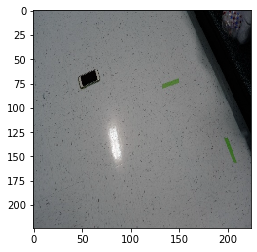

In [57]:
plt.imshow(X[1])

## RCNN

In Regions with CNN there are 4 steps:
<ol>
    <li>Pass image through selective search and generate region proposal</li>
    <li>Calculate IOU - intersection over union - on proposed region</li>
    <li>Transfer learning using proposed regions with labels</li>
    <li>Pass test image to selective search and then pass first 2000 proposed regions and predict class</li>
</ol>

### Data Extraction & Augmenation
First we extract the data from the folder, and we augment right away since the augmentation is set to preserve the center keypoint. We convert centers to bounding boxes after

In [4]:
augment=True

PATH = os.getcwd()
dataset = os.path.join(PATH, 'find_phone')

with open(os.path.join(dataset,'labels.txt')) as inFile:
    labelData=inFile.readlines()

img_h = 224
img_w = 224 

X = []
y = []

for line in labelData:
    imName, x_i, y_i = line.split(' ')
    img = cv2.imread(os.path.join(dataset, imName))
    #img = cv2.imread(os.path.join(dataset, imName))
    X.append(cv2.resize(img, (img_w,img_h)))
    y.append([float(x_i)*img_w,float(y_i)*img_h])
X = np.asarray(X)
y = np.asarray(y)

if augment:
    data = X
    labels = y #Ensure that the centers are transformed appropriately
    datagen = DataGenerator(data, labels)
    datagen.set_probabilities([1, 0.8, 0.3]) #set probabilities for shift, rotate, noise
    X_a, y_a = datagen.generate([datagen.shift, datagen.rotate],len(data)) #duplicate data

    X_train = np.concatenate((X, X_a))
    y_train = np.concatenate((y,y_a))
else:
    X_train = X
    y_train = y

#Shuffle training data
idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

In [5]:
#Given x and y locations of the center, generate small bounding boxes
def gen_bbox(x, y, epsilon_w, epsilon_h):
    assert epsilon_w % 2 == 0
    assert epsilon_h % 2 == 0
    
    x1 = x - epsilon_w/2
    x2 = x + epsilon_w/2
    y1 = y - epsilon_h/2
    y2 = y + epsilon_h/2
    
    return [int(x1), int(x2), int(y1), int(y2)]

epsilon_w = 16
epsilon_h = 16

y_bbox = []

for i in range(len(X_train)):
    x_i, y_i = y_train[i]
    bbox = gen_bbox(int(x_i),int(y_i), epsilon_w, epsilon_h) #convert to pixel values
    y_bbox.append(np.asarray(bbox))
    
y_train = np.asarray(y_bbox) #replace y_train with y_bbox

In [6]:
#bbox is comprised of x1, x2, y1, y2
def get_IOU(bbox1, bbox2):
    #Get intersection points
    x_left = max(bbox1[0], bbox2[0])
    x_right = min(bbox1[1], bbox2[1])
    y_top = max(bbox1[2], bbox2[2])
    y_bot = min(bbox1[3], bbox2[3])
    
    if x_right < x_left or y_bot < y_top: 
        return 0.0
    
    bbox1_area = (bbox1[1] - bbox1[0])*(bbox1[3] - bbox1[2])
    bbox2_area = (bbox2[1] - bbox2[0])*(bbox2[3] - bbox2[2])
    int_area = (x_right - x_left) * (y_bot - y_top)
    
    iou = int_area/(float(bbox1_area) + float(bbox2_area) - float(int_area))
    
    return iou

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # selective search

#loop through images
X_new = []
y_new = []
ious = []

for i in range(len(X_train)):

    #Convert image to type uint - only type compatible with ss
    img = X_train[i]
    img = img.astype(np.uint8)
    bbox = y_train[i]

    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ss_results = ss.process()
    img_out = img.copy()
    counter = 0
    falsecounter = 0
    flag = 0
    fflag = 0
    bflag = 0
    for e, res in enumerate(ss_results):
        if e < 2000 and flag == 0:
            x1,y1,w,h = res #get predicted bbox

            iou = get_IOU(bbox, [x1, x1+w, y1, y1+h])
            ious.append(iou)

            #collect maximum of 30 pos samples
            if counter < 30:
                if iou > 0.70:
                    train_img = img_out[y1:y1+h,x1:x1+w]
                    resized = cv2.resize(train_img, (img_w,img_h))
                    X_new.append(resized)
                    one_hot  = [1,0] #positive
                    y_new.append(one_hot)
                    counter+=1
            else:
                fflag = 1
            if falsecounter < 30:
                if iou < 0.3:
                    train_img = img_out[y1:y1+h,x1:x1+w]
                    resized = cv2.resize(train_img, (img_w,img_h))
                    X_new.append(resized)
                    one_hot = [0,1] #negative
                    y_new.append(one_hot)
                    falsecounter+=1
            else:
                bflag = 1
            if fflag == 1 and bflag == 1:
                print('inside')
                flag=1
                        
X_new = np.asarray(X_new)
y_new = np.asarray(y_new)              

### Model Definition
We are using VGG16, freezing the first 15 layers

In [7]:
vggmodel = VGG16(weights='imagenet', include_top=True)

In [8]:
#Freeze first 15 layers
for layer in (vggmodel.layers)[:15]:
    layer.trainable=False

#replace last layer with dense
fc_out= vggmodel.layers[-2].output
fc_out = layers.Dense(2, activation="softmax")(fc_out)

model = Model(inputs=vggmodel.input, outputs=fc_out)
model.compile(loss = tf.keras.losses.categorical_crossentropy, 
              optimizer=optimizers.Adam(lr=0.0001), 
              metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model_savepath = './rcnn_model'

history = model.fit(X_new, y_new, epochs=1, 
                    validation_split=0.2)

model.save(model_savepath) 

Train on 6330 samples, validate on 1583 samples
3456/6330 [===============>..............] - ETA: 7:18 - loss: 0.0916 - accuracy: 0.9812

In [27]:
def predict(img, model):
    #Convert image to type uint - only type compatible with ss
    img = img.astype(np.uint8)
    
    num_regions = 300 # Cap on number of predicted regions
    
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ss_results = ss.process()
    img_out = img.copy()
    
    X_pred = []
    y_pred = []
    
    for e, res in enumerate(ss_results):
        if e < num_regions:
            x1,y1,w,h = res #get predicted bbox
            pred_img = img_out[y1:y1+h,x1:x1+w]
            resized = cv2.resize(pred_img, (img_w,img_h))
            X_pred.append(resized)
            y_pred.append([x1, x1+w, y1, y1+h])
        else:
            break
    
    confidence_scores = model.predict(np.asarray(X_pred))
    
    #In this case we have one phone per image, however this could be thresholded to include multiple instances
    idx_max = np.where(confidence_scores[:,0] == max(confidence_scores[:,0]))[0][0]
    
    bbox = y_pred[idx_max]
    return bbox
    
        

Predicted Center
[0.25, 0.6160714285714286]


Actual Center
[0.2388 0.6012]
Predicted Center
[0.25669642857142855, 0.3125]


Actual Center
[0.2551 0.3129]
Predicted Center
[0.7053571428571429, 0.7142857142857143]


Actual Center
[0.7122 0.7117]
Predicted Center
[0.53125, 0.48660714285714285]


Actual Center
[0.5286 0.4877]
Predicted Center
[0.7678571428571429, 0.33035714285714285]


Actual Center
[0.7714 0.3252]
Predicted Center
[0.11607142857142858, 0.3549107142857143]


Actual Center
[0.1122 0.3466]
Predicted Center
[0.8504464285714286, 0.16517857142857142]


Actual Center
[0.8449 0.1564]
Predicted Center
[0.48214285714285715, 0.4486607142857143]


Actual Center
[0.4837 0.4509]
Predicted Center
[0.26339285714285715, 0.8035714285714286]


Actual Center
[0.2612 0.8037]
Predicted Center
[0.6897321428571429, 0.3392857142857143]


Actual Center
[0.6551 0.3466]
Predicted Center
[0.19196428571428573, 0.11383928571428571]


Actual Center
[0.1878 0.1104]
Predicted Center
[0.7834821428571429, 

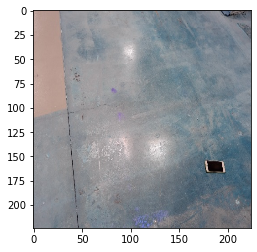

In [43]:
def get_center_norm(bbox, img_w, img_h):
    x1,x2,y1,y2 = bbox
    x_i = x1 + (x2-x1)/2.0
    y_i = y1 + (y2-y1)/2.0
    
    return [x_i/img_w, y_i/img_h]

def accuracy(truth, pred):
    return abs(np.linalg.norm(truth) - np.linalg.norm(pred))

count_pos = 0
num = 20

for i in range(num):
    img = X[i]
    plt.imshow(img)
    bbox = predict(img, model)

    truth = y[i]
    pred = get_center_norm(bbox, img_w, img_h)

#     cv2.rectangle(img, (int(bbox[0]),int(bbox[2])),(int(bbox[1]),int(bbox[3])),(255,255))
#     plt.imshow(img)

    print("Predicted Center\n" + str(pred))
    print("\n\nActual Center\n" + str(truth))
    
    if accuracy(truth, pred) < 0.05:
        count_pos+=1

print("\n\n Accuracy is " + str(float(count_pos)/num))

In [47]:
y[12]

array([0.602 , 0.1135])

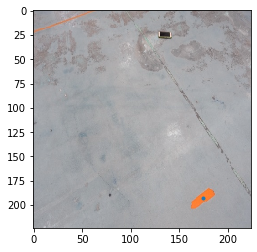

In [56]:
img = X[12]

pred = [0.7790178571428571*img_w, 0.8638392857142857*img_h]
truth = y[12]*[img_w,img_h]
plt.imshow(img)
plt.plot(int(pred[0]), int(pred[1]), marker='.')
plt.show()

In [52]:
pred

[174.5, 193.5]

In [53]:
truth

array([134.848,  25.424])

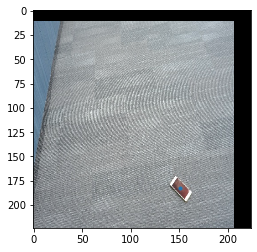

In [52]:
i= 4
plt.imshow(X_train[i])
x_i,y_i = y_train[i]
plt.plot(int(x_i),int(y_i), marker='.')

In [8]:
y[0]*[img_w,img_h]

array([ 53.4912, 134.6688])

In [39]:
y_train[100]

array([47.5328, 81.088 ])